# Sthype

This is an introduction to the the package `Sthype`. With `Sthype`, you can merge `spatial graphs` representing a network growth into one `spatial temporal graph`. From this state, many dynamics analysis can be done. Processing the `growth speed` of the network is an example.

## 1. Load the graphs

This package uses graph from the `Networkx` package. The graphs representing the growth should be `Networkx` graphs. One more particularity, is that the graphs edges should have the attribute pixels being a list of doublet representing the path of the edge, and vertex/node should have the attribute position being a doublet representing the position of the vertex. The doublet at the border of the attribute pixels of the edge (a,b) should match the positions of the vertex a and b.

Also, vertex are int.

For the purpose of the example, we load some graphs. But you can import your own:

In [2]:
import os
import pickle

graphs = []

str_directory = "/home/ipausers/hamzaoui/Documents/Data/Graphs/482_20230908"
directory = os.fsencode(str_directory)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    file_path = os.path.join(str_directory, filename)
    if filename.endswith('pickle'):
        graphs.append((filename, pickle.load(open(file_path, 'rb'))))

graphs.sort()
graphs = [graph for _, graph in graphs]
print(f'{len(graphs)} graphs loaded')

21 graphs loaded


These graphs have the attributes :

In [8]:
graph = graphs[0]
for node, node_data in graph.nodes(data=True):
    print(f'Nodes attributes : {list(node_data.keys())}')
    break
for u, v, edge_data in graph.edges(data=True):
    print(f'Edges attributes : {list(edge_data.keys())}')
    break

Nodes attributes : ['position']
Edges attributes : ['weight', 'width', 'pixels']


As you can see, there are two other attributes to the edge: `weight` and `node`. It can be ignored for the moment, but it will be shown later that custom attributes from `spatial graphs` are transfered to the resulting `spatial temporal graph`.

## 2. Spatial Graph

### Init

Now that the graphs from the networkx package are loaded, they can be converted into `spatial graph`:

In [9]:
from sthype import SpatialGraph

spatial_graphs = [SpatialGraph(graph) for graph in graphs]
spatial_graph = spatial_graphs[-1]
sg = spatial_graph

`Spatial Graphs` is a subclass of nx.Graph and have two built in functions:

- `edge_pixels(node1: int, node2: int) -> LineString` that returns the line from node1 to node2 where `LineString` is a class from the package `shapely`
- `node_position(self, node: int) -> Point` that returns the position of the node as a `Line` class from `shapely`

Attributes from the original graphs remain.

### Plot

They can also be plotted with `plot_spatial_graph` and `plot_spatial_graph_node` (plot a section of the graph around a node):

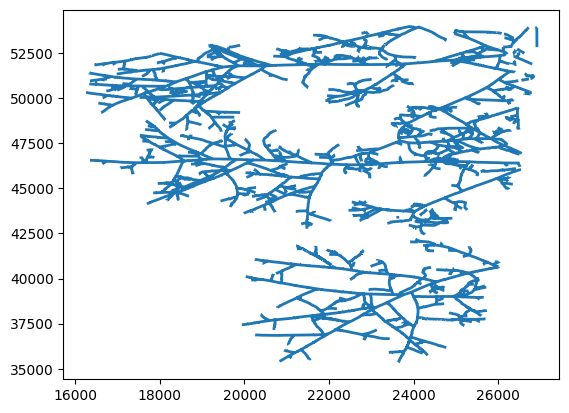

In [11]:
from sthype.plot import plot_spatial_graph

plot_spatial_graph(sg);

## 3. Spatial Temporal Graph

### Init

Using the `spatial graphs`, a `spatial temporal graph` can be created as follow. It is a subclass of nx.Graph too.

In [12]:
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs
import numpy as np

spatial_temporal_graph = spatial_temporal_graph_from_spatial_graphs(spatial_graphs, np.arange(len(spatial_graphs)), verbose=1)
stg = spatial_temporal_graph

Segmentation
Edge Activation
Comparing with graph 20
Comparing with graph 19
Comparing with graph 18
Comparing with graph 17
Comparing with graph 16
Comparing with graph 15
Comparing with graph 14
Comparing with graph 13
Comparing with graph 12
Comparing with graph 11
Comparing with graph 10
Comparing with graph 9
Comparing with graph 8
Comparing with graph 7
Comparing with graph 6
Comparing with graph 5
Comparing with graph 4
Comparing with graph 3
Comparing with graph 2
Comparing with graph 1
Comparing with graph 0


`Spatial Temporal Graphs` (`stg`) is basically the last `spatial temporal graph` with new attributes:

In [15]:
for node, node_data in spatial_temporal_graph.nodes(data=True):
    print("Node attributes :", *node_data.keys())
    break

for node1, node2, edge_data in spatial_temporal_graph.edges(data=True):
    print("Edge attributes :", *edge_data.keys())
    print("Attributes in '20' :", *edge_data['20'].keys())
    break

Node attributes : position
Edge attributes : center length initial_edge initial_edge_attributes centers activation activation_timestamp 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 corrected_activation hyperedge post_hyperedge_activation
Attributes in '20' : weight width


The `activation` attribute is the timestep the edge was first detected by the algorithm. The `length` attribute is the length of the edge. The `centers` attribute are the center through time of this edge. The number from `0` to the `last_timestep` are where custom attributes are stored. With the `activation` attribute, edges can be put together as an hyperedge. They are forming a "natural path". Each edge is given an `hyperedge` index. By putting edges together, a corrected activation can be processed: `post_hyperedge_activation`.

### Plot

The result can be plotted with `plot_spatial_temporal_graph`, `plot_spatial_temporal_graph_node` (plot around a node) and `plot_spatial_temporal_graph_hyperedge` (plot around an hyperedge):

Colored by activation:

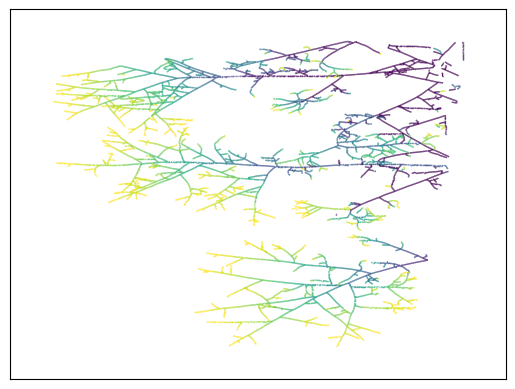

In [16]:
from sthype.plot import plot_spatial_temporal_graph

plot_spatial_temporal_graph(spatial_temporal_graph, color_group='activation')

Colored by hyperedge:

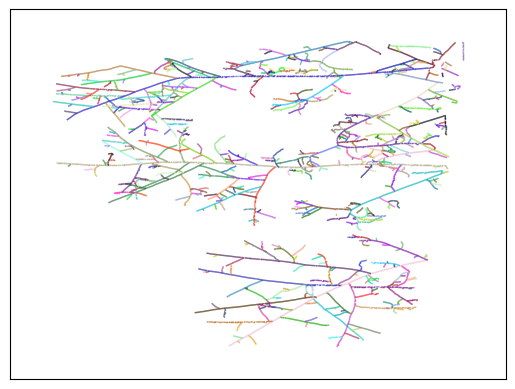

In [17]:
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='hyperedge')

Outline an hyperedge:

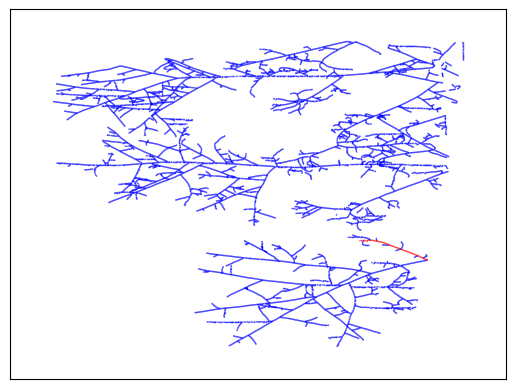

In [18]:
plot_spatial_temporal_graph(spatial_temporal_graph, color_group=5)

Around a region at a given timestep:

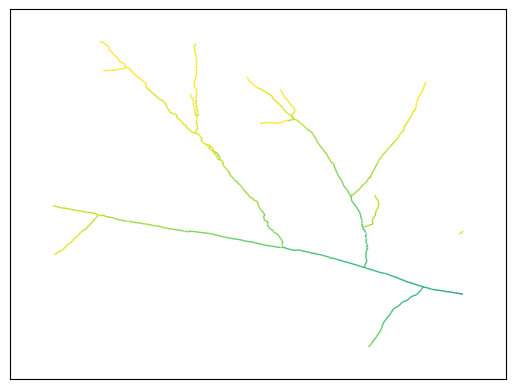

In [19]:
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='activation', region=((21000, 40000), (23000, 42000)), time=20)

### Stg class functions

#### Get_Initial_Graph

The class function `get_initial_graph()` returns the graph with every edges meeting at a degree two node being merged.

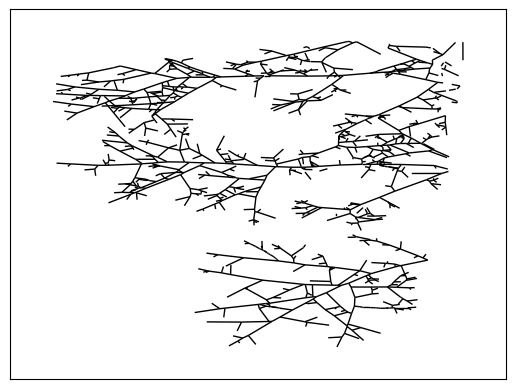

In [30]:
initial_graph = stg.get_initial_graph()
pos = {node: (p.x, p.y) for node, p in stg.positions.items()}

import networkx as nx
nx.draw_networkx(initial_graph, pos, with_labels=False, nodelist=[])

It has the same attributes as the stg :

In [35]:
for node, node_data in initial_graph.nodes(data=True):
    print("Node attributes :", *node_data.keys())
    break

for node1, node2, edge_data in initial_graph.edges(data=True):
    print("Edge attributes :", *edge_data.keys())
    break

Node attributes : position
Edge attributes : edges time_interval center length initial_edge initial_edge_attributes centers activation activation_timestamp 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 corrected_activation hyperedge


#### Get_Graph_At

The class function `get_graph_at(t)` returns the initial_graph at the timestep `t`, i.e. all the edges that appeared before the time step `t`. As in `get_graph_at` every edges at a degree two intersection are merged into `initial_edges`.

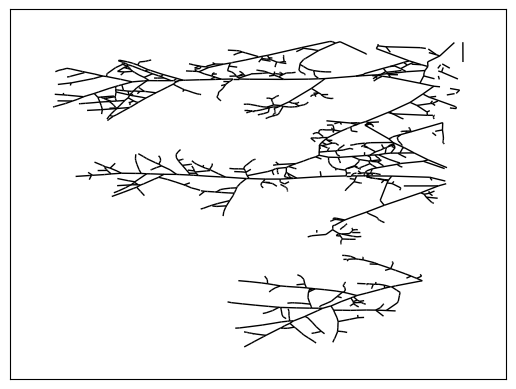

In [25]:
g15 = stg.get_graph_at(15)
pos = {node: (p.x, p.y) for node, p in stg.positions.items()}
nx.draw_networkx(g15, pos, with_labels=False, nodelist=[])

The `initial_edges` attributes are:

- `pixels` : a list of `shapely Point` representing the path of the `initial_edge`
- `activation` : being the moment the `initial_edge` appeared
- `hyperedge` : the hyperedge index of the `initial_edge`
- `attributes` : a dictionnary having as keys the custom attributes in the original graph and as values list of the attribute value for each edge composing the `initial_edges`

In [38]:
for node, node_data in g15.nodes(data=True):
    print("Node attributes :", *node_data.keys())
    break

for node1, node2, edge_data in g15.edges(data=True):
    print("Edge attributes :", *edge_data.keys())
    print("attributes :", *edge_data['attributes'].keys())
    print("pixels :", edge_data['pixels'])
    print("width :", edge_data['attributes']['width'])
    print("The width of the initial_edge should be the median:", np.median(edge_data['attributes']['width']))
    break

Node attributes : position
Edge attributes : pixels activation hyperedge attributes
attributes : weight width
pixels : [<POINT (23983 37209.201)>, <POINT (23983.765 37218.765)>, <POINT (23985 37228.136)>, <POINT (23986 37237.604)>, <POINT (23988 37246.657)>, <POINT (23990 37255.125)>, <POINT (23991 37264.593)>, <POINT (23993 37273.647)>, <POINT (23994 37283.114)>, <POINT (23997 37291.168)>, <POINT (23998 37300.636)>, <POINT (23999.104 37310)>, <POINT (24001 37318.571)>, <POINT (24003.442 37327.442)>, <POINT (24006 37336.264)>, <POINT (24008 37345.318)>, <POINT (24010 37354.371)>, <POINT (24012 37363.425)>, <POINT (24014 37372.479)>, <POINT (24016 37381.532)>, <POINT (24017 37391)>]
width : [5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285, 5.3805285]
The width of the initial_edge should be the median: 5.3805285


### Application Example

In this part, a plot of the total length of the graph through time will be plotted

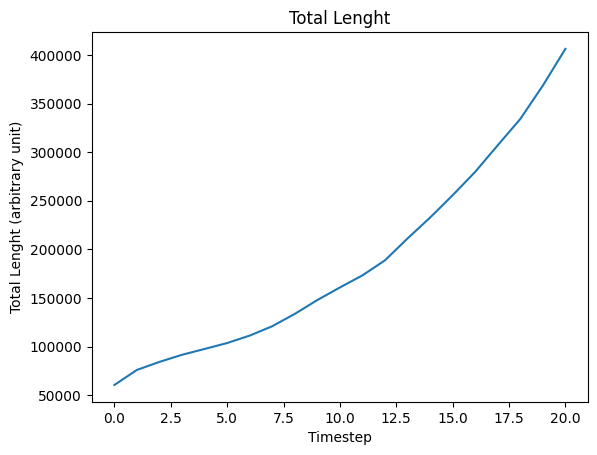

In [42]:
lengths_added = [0 for _ in range(len(spatial_graphs))]
for _, _, edge_data in stg.edges(data=True):
    lengths_added[edge_data['activation']] += edge_data['length']

lengths = np.cumsum(lengths_added)

import matplotlib.pyplot as plt
plt.plot(lengths)
plt.title('Total Lenght')
plt.xlabel('Timestep')
plt.ylabel('Total Lenght (arbitrary unit)');